In [24]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import ipaddress
import json

import matplotlib.pyplot as plt
import pandas as pd
#import tensorflow.keras.layers as layers
#from tensorflow.keras.models import Model
import numpy as np
from sklearn import decomposition
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity

from resources.firewall_rule import FirewallRule

In [36]:
# PCA Visualization

def dimensionality_reduce(dataset, n_components):
    """Reduce the input feature set to lower dimension space
    Args:
      dataset(Array): Input numpy array
      n_components(int): Number of dimensions to decompose

    Returns:
      principal_components: Dataset in reduced dimension space
    """
    principal_components = decomposition.PCA(n_components=n_components)
    return principal_components, principal_components.fit_transform(dataset)


def visualize_2d(dataset, cmap=None):
    """
    Visualize the low dimesional space image
    Args:
      dataset(array): 3 dimensional input dataset
      cmap(str): Colormap for visualization
    """
    assert (dataset.shape[1] == 3), "Dataset must have only 2 feature columns and 1 index column."
    
    %matplotlib notebook
    
    cmap = plt.cm.RdYlGn

    mp = {}
    for i in range(0, dataset.shape[0]):
        key = str(dataset.loc[i, 0]) + " " + str(dataset.loc[i, 1])
        # print(key)
        mp[key] = dataset.loc[i, 'identifier']
    fig ,ax = plt.subplots(figsize=(20,10))

    sc = plt.scatter(dataset[[0]], dataset[[1]], gid=dataset[['identifier']], s=100, cmap=cmap)

    annot = ax.annotate("", xy=(0,0), xytext=(-300,10),textcoords="offset points",
                        bbox=dict(boxstyle="round", fc="w"),
                        arrowprops=dict(arrowstyle="->"))
    annot.set_visible(False)

    def update_annot(ind):
        pos = sc.get_offsets()[ind["ind"][0]]
        annot.xy = pos
        key = str(dataset.loc[ind["ind"][0], 0]) + " " + str(dataset.loc[ind["ind"][0], 1])
        text = mp[key]
        annot.set_text(text)
        annot.get_bbox_patch().set_alpha(0.4)


    def hover(event):
        vis = annot.get_visible()
        if event.inaxes == ax:
            cont, ind = sc.contains(event)
            if cont:
                update_annot(ind)
                annot.set_visible(True)
                fig.canvas.draw_idle()
            else:
                if vis:
                    annot.set_visible(False)
                    fig.canvas.draw_idle()

    fig.canvas.mpl_connect("motion_notify_event", hover)

    plt.show()

def principal_components(pca, dataset):
    """
    Returns the most important components when Dimensionality is reduced.
    pca: PCA object
    dataset:
    :return:
     Varaiance:
     (n * 1 array) Matrix of Variance of the Matrices
     (d*n array) d principal components fed into original feature space
     (Covariance Matrix): Matrix of pairwise feature co-relation
    """
    pca.fit_transform(dataset)
    return (pca.explained_variance_, pca.components_, np.cov(dataset.T))


action                      0
creation_timestamp        173
dest_ip_addr               -1
direction                   0
disabled                    0
full_name                  60
ip_protocol                 0
name                       33
network                    15
org_id                      0
ports                       3
service_account            11
source_ip_addr              1
source_service_account     -1
source_tag                 -1
tag                        -1
Name: 0, dtype: int16
      action  creation_timestamp  dest_ip_addr     direction  disabled  \
PC-1    -0.0            0.719373  5.551115e-17 -0.000000e+00      -0.0   
PC-2    -0.0            0.343423  1.110223e-16 -1.110223e-16      -0.0   

      full_name  ip_protocol      name   network  org_id     ports  \
PC-1  -0.225319    -0.000436 -0.579028 -0.013305    -0.0 -0.004915   
PC-2   0.929933    -0.000454  0.075274  0.104712    -0.0  0.005401   

      service_account  source_ip_addr  source_service_account  s

<IPython.core.display.Javascript object>


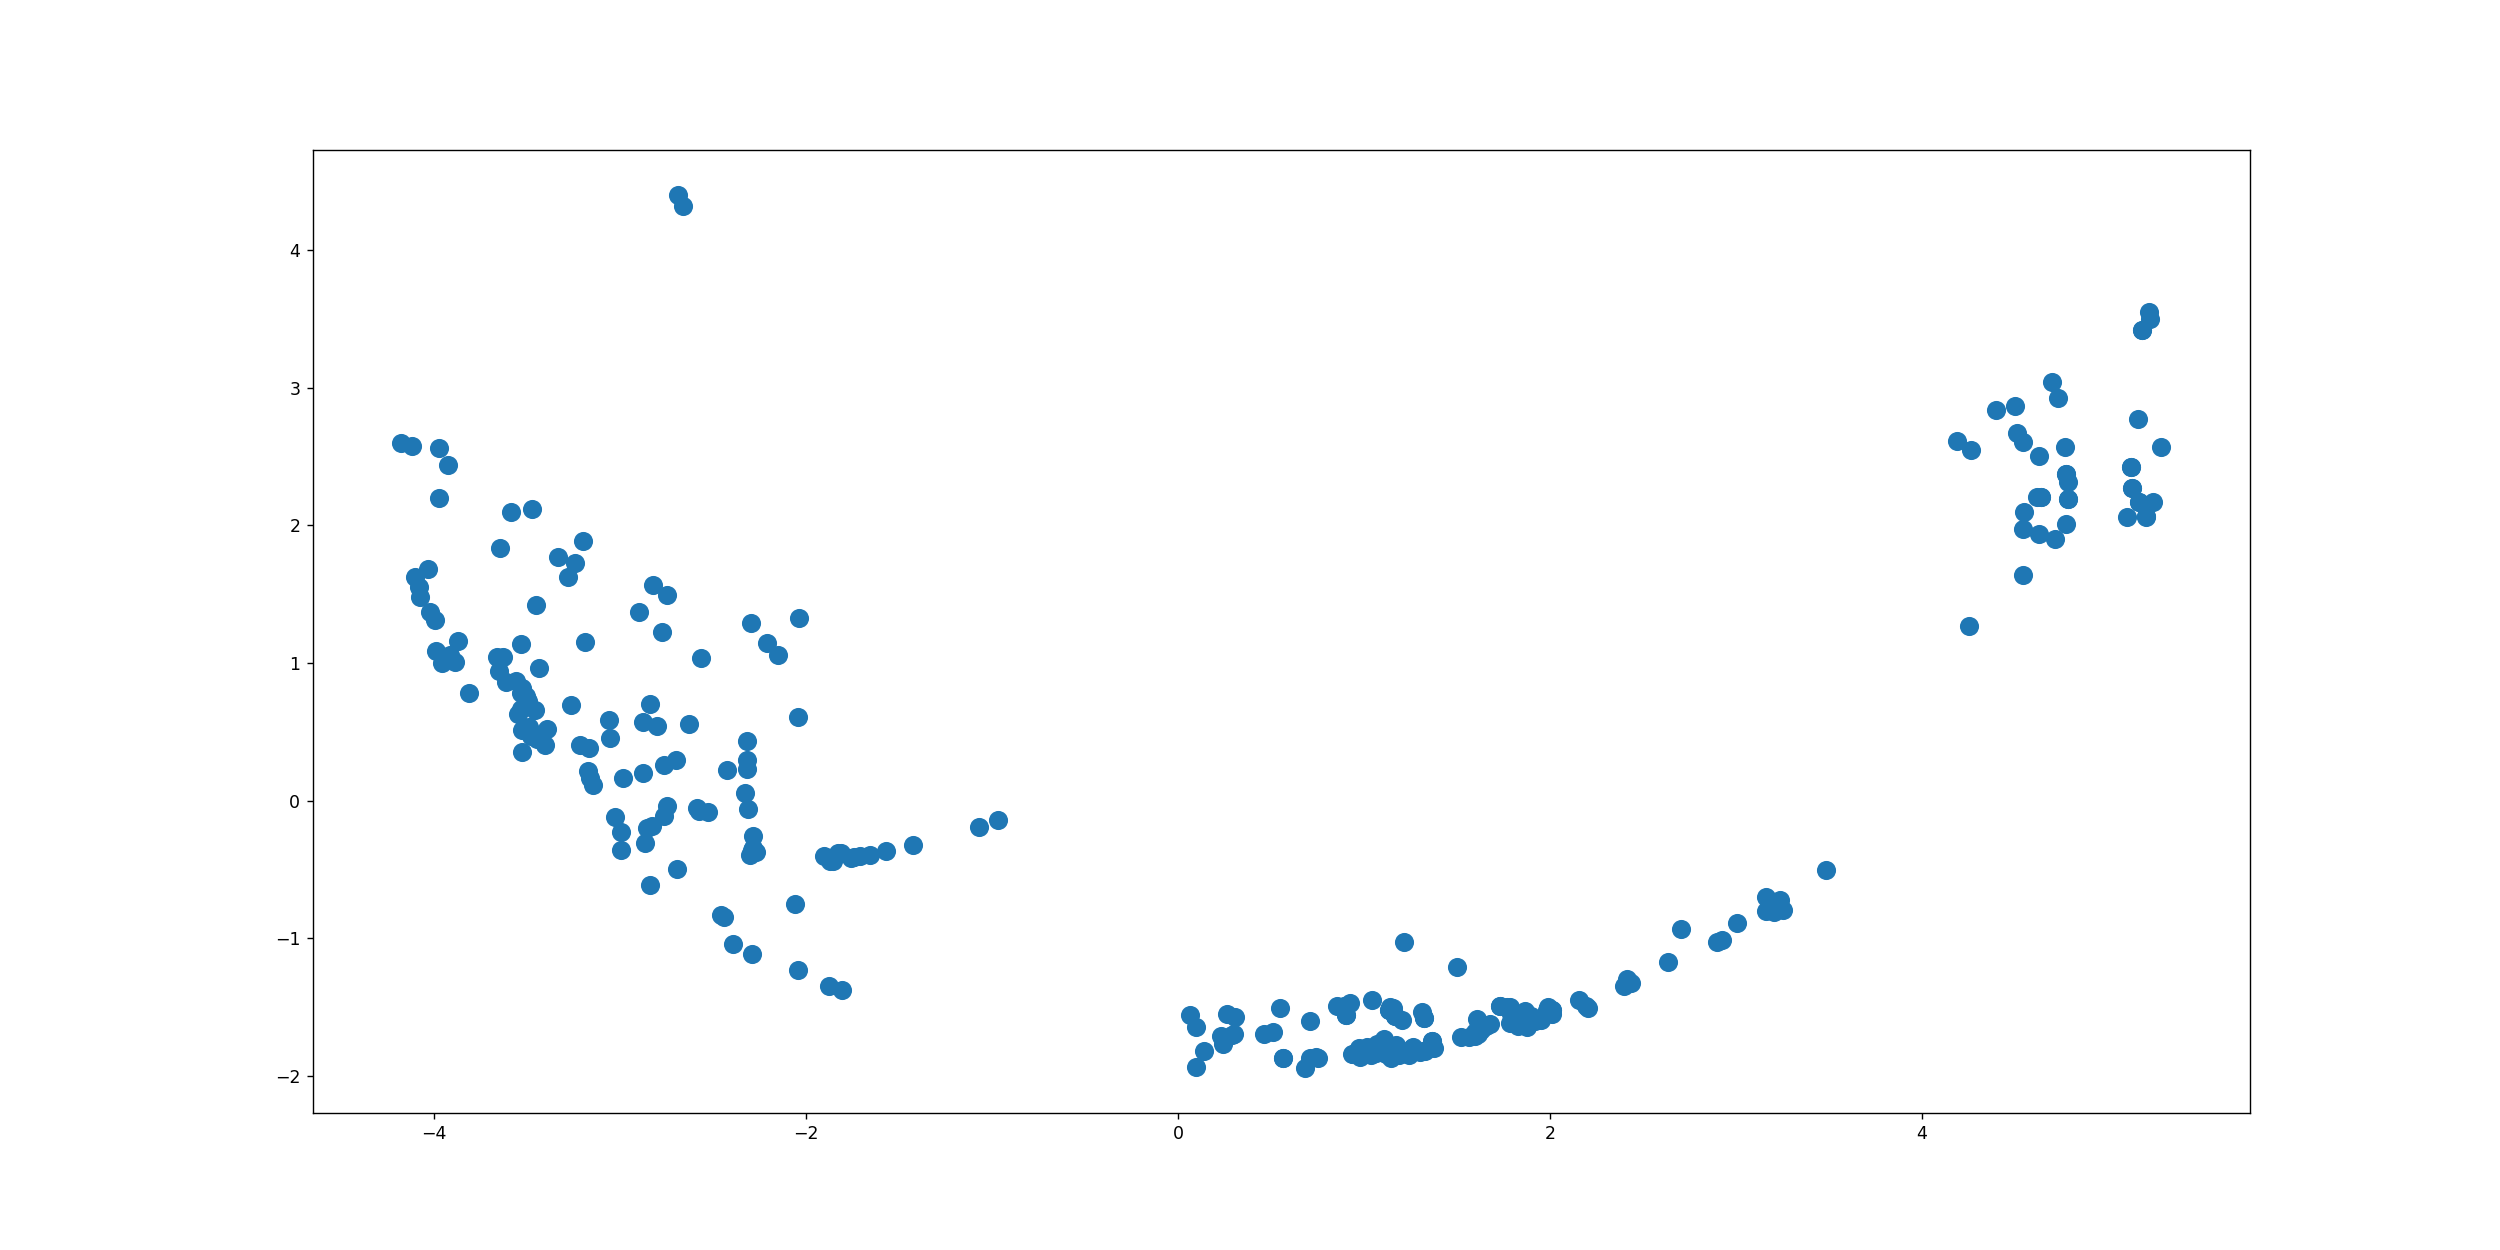

In [42]:
# Data processing / Feature engineering

# Approach #1, treats everything as categorical values

def pre_process_firewall_data(resource_data_json):
    """Pre process resource data.

    Args:
        resource_data_json (list): A list of resource data in json format.
        selected_features (list): A list of selected features, if the
            list is empty, we will include all the features.

    Returns:
        DataFrame: DataFrame table with all the resource_data.
        str: Full name column.
        str: Name of the firewall rule.
    """
    df = pd.DataFrame(resource_data_json)
    full_name_column, name = df['full_name'], df['name']

    df['creation_timestamp'] = df['creation_timestamp'].astype('category').cat.codes
    df['direction'] = df['direction'].astype('category').cat.codes
    df['action'] = df['action'].astype('category').cat.codes
    df['disabled'] = df['disabled'].astype('category').cat.codes
    df['ip_protocol'] = df['ip_protocol'].astype('category').cat.codes
    df['ports'] = df['ports'].astype('category').cat.codes
    df['org_id'] = df['org_id'].astype('category').cat.codes
    df['source_ip_addr'] = df['source_ip_addr'].astype('category').cat.codes
    df['dest_ip_addr'] = df['dest_ip_addr'].astype('category').cat.codes
    df['service_account'] = df['service_account'].astype('category').cat.codes
    df['tag'] = df['tag'].astype('category').cat.codes
    df['full_name'] = df['full_name'].astype('category').cat.codes
    df['ip_protocol'] = df['ip_protocol'].astype('category').cat.codes
    df['network'] = df['network'].astype('category').cat.codes
    df['source_service_account'] = df['source_service_account'].astype('category').cat.codes
    df['source_tag'] = df['source_tag'].astype('category').cat.codes
    df['name'] = df['name'].astype('category').cat.codes
    return df, full_name_column, name

with open('sample_datasets/dataset_firewall.json') as firewall_dataset:
    firewall_rules = json.load(firewall_dataset)

    flattened_firewall_rules = FirewallRule.flatten_firewall_rules(firewall_rules)

    flattened_firewall_rules_dict = [i.to_dict() for i in flattened_firewall_rules]

    df_filtered, full_name_col, name_col = pre_process_firewall_data(
        flattened_firewall_rules_dict)
    print (df_filtered.iloc[0])
    
    
pca, pca_2 = dimensionality_reduce(df_filtered, 2)

print (pd.DataFrame(pca.components_,columns=df_filtered.columns,index = ['PC-1','PC-2']))

# weighted_dimension, components, covariance_matrix = principal_components(pca, df_filtered)
# print ("Explained Variance:", weighted_dimension, "Covariance Matrix:", covariance_matrix)
# print ("COMPONENTS SPREAD", components)
# print ("SHAPE OF COVARIANCE MATRIX", covariance_matrix.shape)

# pca_2 = pd.DataFrame(pca_2)

# pca_2['full_name'] = full_name_col

# visualize_2d(pca_2)
print ("")
print ("====== Using similarity matrix ========")

sim_matrix = cosine_similarity(df_filtered)

pca, pca_2 = dimensionality_reduce(sim_matrix, 2)

pca_2 = pd.DataFrame(pca_2)

pca_2['full_name'] = full_name_col
pca_2['name'] = name_col

pca_2['identifier'] = pca_2['full_name'].map(lambda x: str(x) + ' ') + pca_2['name']

pca_2 = pca_2.drop(columns=['full_name', 'name'])

visualize_2d(pca_2)


action                          0
creation_timestamp            173
direction                       0
disabled                        0
full_name                      60
ip_protocol                     0
network                        15
ports                           3
service_account                11
source_service_account         -1
source_tag                     -1
tag                            -1
source_subnet_count       8388608
source_ip_offset_1              1
source_ip_offset_2              1
source_ip_offset_3              0
source_ip_offset_4              1
dest_subnet_count              -1
dest_ip_offset_1                0
dest_ip_offset_2                0
dest_ip_offset_3                0
dest_ip_offset_4                0
Name: 0, dtype: int64
      action  creation_timestamp  direction      disabled     full_name  \
PC-1     0.0        2.114215e-09        0.0  1.102026e-37 -1.016683e-08   
PC-2    -0.0        9.227436e-01       -0.0  5.551115e-17  2.155481e-01   

    

<IPython.core.display.Javascript object>


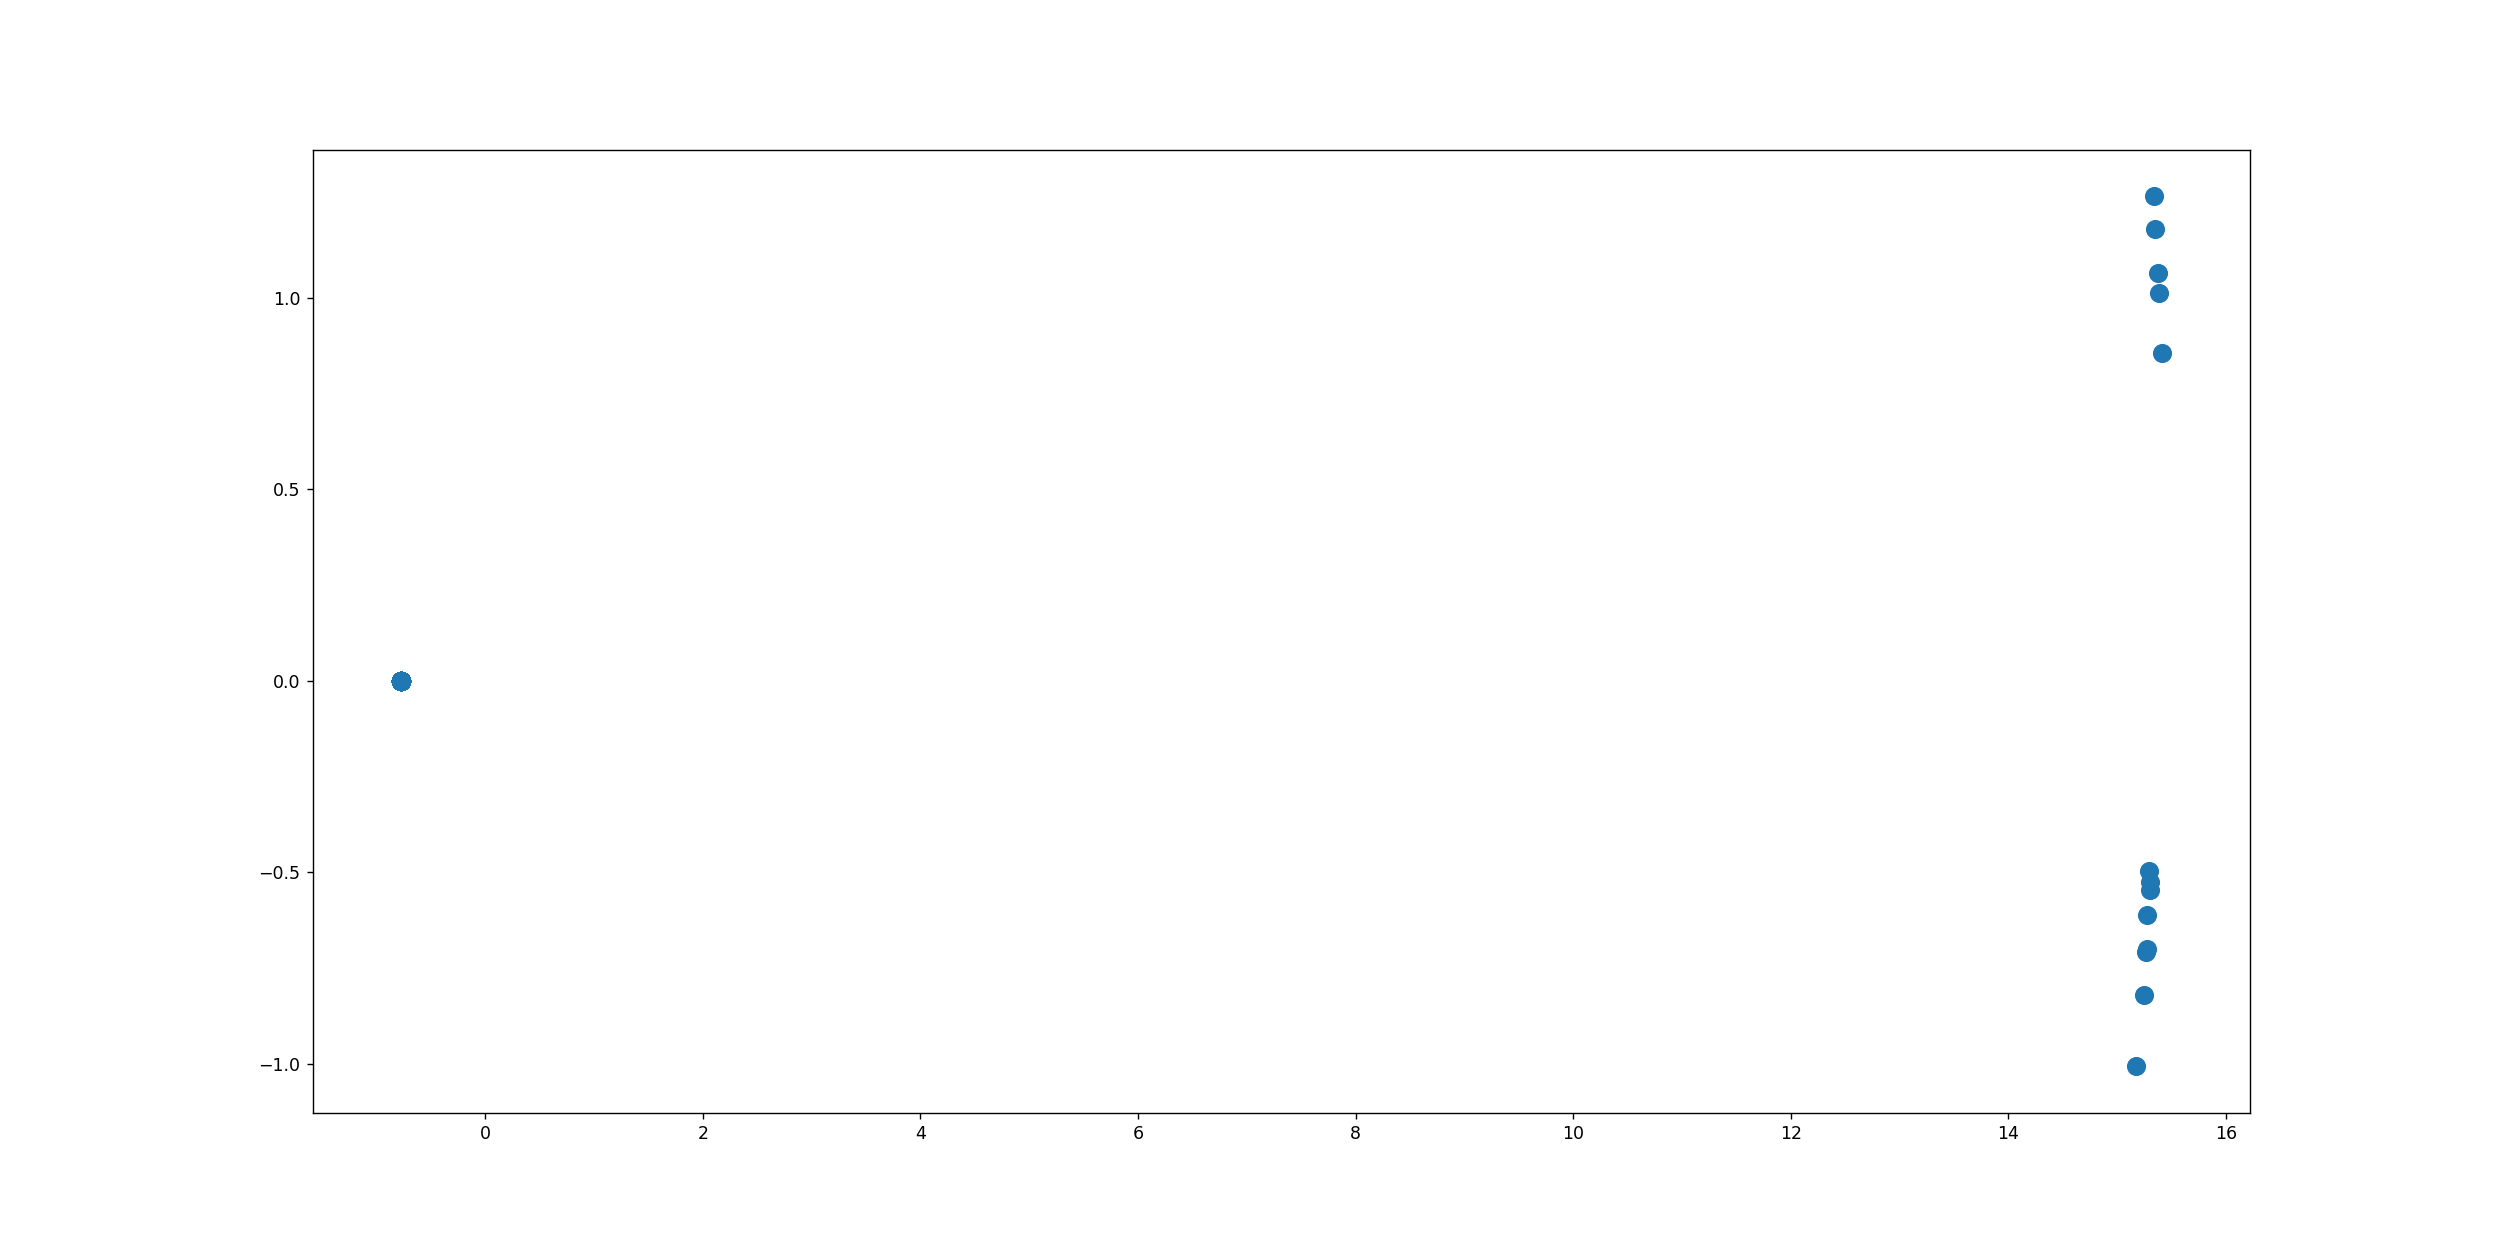

In [43]:
# Approach #2, penalized looser subnet exponentially

def pre_process_firewall_data(resource_data_json):
    """Pre process resource data.

    Args:
        resource_data_json (list): A list of resource data in json format.
        selected_features (list): A list of selected features, if the
            list is empty, we will include all the features.

    Returns:
        DataFrame: DataFrame table with all the resource_data.
        str: Full name column.
        str: Name of the firewall rule.
    """

    def subnet_count(ip_addr):
        """Covert ip address."""
        if ip_addr and '/' in ip_addr:
            _, subnet = ip_addr.split('/')
            return 2 ** (32 - int(subnet))
        return -1

    df = pd.DataFrame(resource_data_json)
    full_name_column, name_column = df['full_name'], df['name']

    df['creation_timestamp'] = df['creation_timestamp'].astype('category').cat.codes
    df['direction'] = df['direction'].astype('category').cat.codes
    df['action'] = df['action'].astype('category').cat.codes
    df['disabled'] = df['disabled'].astype('category').cat.codes
    df['ip_protocol'] = df['ip_protocol'].astype('category').cat.codes
    df['ports'] = df['ports'].astype('category').cat.codes

    df['source_subnet_count'] = df['source_ip_addr'].apply(subnet_count)
    source_ips = df['source_ip_addr'].str.replace('/', '').str.split('.', expand = True)
    df['source_ip_offset_1'] = source_ips[0] if len(source_ips.columns) > 1 else ''
    df['source_ip_offset_1'] = df['source_ip_offset_1'].astype('category').cat.codes
    df['source_ip_offset_2'] = source_ips[1] if len(source_ips.columns) > 1 else ''
    df['source_ip_offset_2'] = df['source_ip_offset_2'].astype('category').cat.codes
    df['source_ip_offset_3'] = source_ips[2] if len(source_ips.columns) > 1 else ''
    df['source_ip_offset_3'] = df['source_ip_offset_3'].astype('category').cat.codes
    df['source_ip_offset_4'] = source_ips[3] if len(source_ips.columns) > 1 else ''
    df['source_ip_offset_4'] = df['source_ip_offset_4'].astype('category').cat.codes

    df['dest_subnet_count'] = df['dest_ip_addr'].apply(subnet_count)
    dest_ips = df['dest_ip_addr'].str.replace('/', '').str.split('.', expand = True)
    df['dest_ip_offset_1'] = dest_ips[0] if len(dest_ips.columns) > 1 else ''
    df['dest_ip_offset_1'] = df['dest_ip_offset_1'].astype('category').cat.codes
    df['dest_ip_offset_2'] = dest_ips[1] if len(dest_ips.columns) > 1 else ''
    df['dest_ip_offset_2'] = df['dest_ip_offset_2'].astype('category').cat.codes
    df['dest_ip_offset_3'] = dest_ips[2] if len(dest_ips.columns) > 1 else ''
    df['dest_ip_offset_3'] = df['dest_ip_offset_3'].astype('category').cat.codes
    df['dest_ip_offset_4'] = dest_ips[3] if len(dest_ips.columns) > 1 else ''
    df['dest_ip_offset_4'] = df['dest_ip_offset_4'].astype('category').cat.codes

    df = df.drop(columns=['source_ip_addr', 'dest_ip_addr', 'org_id', 'name'])

    df['service_account'] = df['service_account'].astype('category').cat.codes
    df['tag'] = df['tag'].astype('category').cat.codes
    df['full_name'] = df['full_name'].astype('category').cat.codes
    df['ip_protocol'] = df['ip_protocol'].astype('category').cat.codes
    df['network'] = df['network'].astype('category').cat.codes
    df['source_service_account'] = df['source_service_account'].astype('category').cat.codes
    df['source_tag'] = df['source_tag'].astype('category').cat.codes

    return df, full_name_column, name_column

with open('sample_datasets/dataset_firewall.json') as firewall_dataset:
    firewall_rules = json.load(firewall_dataset)

    flattened_firewall_rules = FirewallRule.flatten_firewall_rules(firewall_rules)

    flattened_firewall_rules_dict = [i.to_dict() for i in flattened_firewall_rules]

    df_filtered, full_name_col, name_col = pre_process_firewall_data(
        flattened_firewall_rules_dict)
    print (df_filtered.iloc[0])
    
    
pca, pca_2 = dimensionality_reduce(df_filtered, 2)

print (pd.DataFrame(pca.components_,columns=df_filtered.columns,index = ['PC-1','PC-2']))

# weighted_dimension, components, covariance_matrix = principal_components(pca, df_filtered)
# print ("Explained Variance:", weighted_dimension, "Covariance Matrix:", covariance_matrix)
# print ("COMPONENTS SPREAD", components)
# print ("SHAPE OF COVARIANCE MATRIX", covariance_matrix.shape)

# pca_2 = pd.DataFrame(pca_2)

# pca_2['full_name'] = full_name_col

# visualize_2d(pca_2)
print ("")
print ("====== Using similarity matrix ========")

sim_matrix = cosine_similarity(df_filtered)

pca, pca_2 = dimensionality_reduce(sim_matrix, 2)

pca_2 = pd.DataFrame(pca_2)

pca_2['full_name'] = full_name_col
pca_2['name'] = name_col

pca_2['identifier'] = pca_2['full_name'].map(lambda x: str(x) + ' ') + pca_2['name']

pca_2 = pca_2.drop(columns=['full_name', 'name'])

visualize_2d(pca_2)

action                      0
creation_timestamp        687
direction                   1
disabled                    0
full_name                 461
ip_protocol                 0
network                   103
ports                      19
service_account            -1
source_service_account     -1
source_tag                 -1
tag                        92
source_subnet_count         0
source_ip_offset_1         12
source_ip_offset_2         40
source_ip_offset_3         29
source_ip_offset_4         78
dest_subnet_count          -1
dest_ip_offset_1           -1
dest_ip_offset_2           -1
dest_ip_offset_3           -1
dest_ip_offset_4           -1
Name: 0, dtype: int64
        action  creation_timestamp  direction      disabled  full_name  \
PC-1  0.000008            0.300089   0.000004  7.661712e-33  -0.928321   
PC-2 -0.000008           -0.950516   0.000018  2.426980e-33  -0.288668   

      ip_protocol   network     ports  service_account  \
PC-1     0.000049 -0.211649 -0.004955

<IPython.core.display.Javascript object>


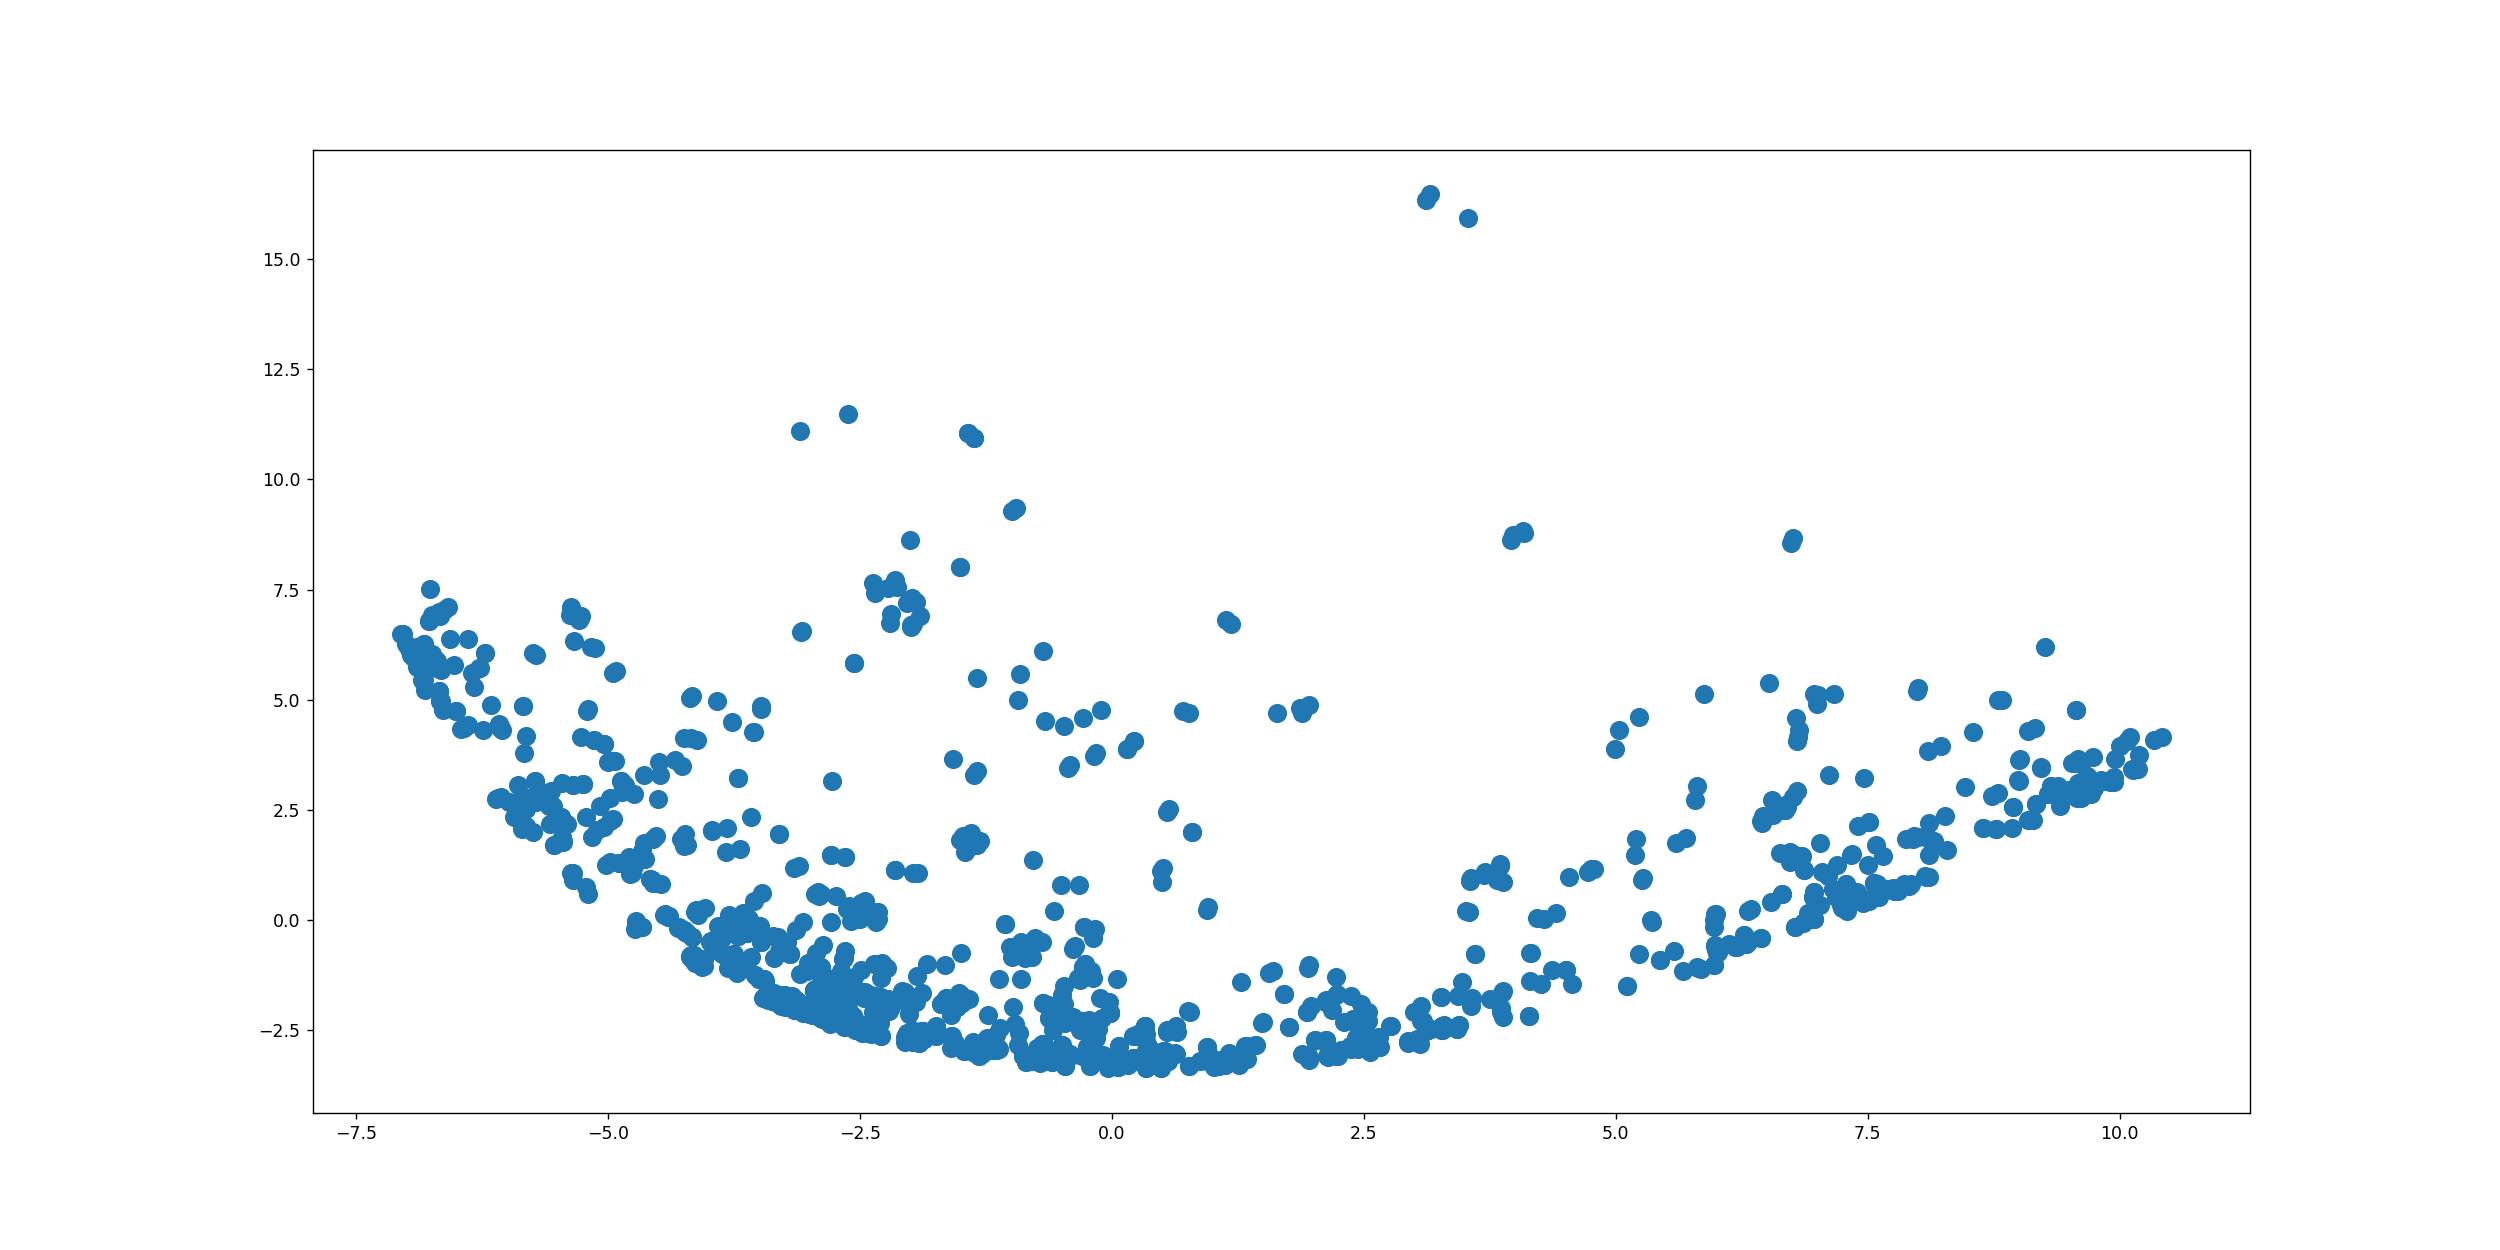

In [44]:
# Approach #3, penalized looser subnet with a multiple of 10

def pre_process_firewall_data(resource_data_json):
    """Pre process resource data.

    Args:
        resource_data_json (list): A list of resource data in json format.
        selected_features (list): A list of selected features, if the
            list is empty, we will include all the features.

    Returns:
        DataFrame: DataFrame table with all the resource_data.
        str: Full name column.
        str: Name of the firewall rule.
    """

    def subnet_count(ip_addr):
        """Covert ip address."""
        if ip_addr and '/' in ip_addr:
            _, subnet = ip_addr.split('/')
            return 10 * (32 - int(subnet))
        return -1

    df = pd.DataFrame(resource_data_json)
    full_name_column, name_column = df['full_name'], df['name']

    df['creation_timestamp'] = df['creation_timestamp'].astype('category').cat.codes
    df['direction'] = df['direction'].astype('category').cat.codes
    df['action'] = df['action'].astype('category').cat.codes
    df['disabled'] = df['disabled'].astype('category').cat.codes
    df['ip_protocol'] = df['ip_protocol'].astype('category').cat.codes
    df['ports'] = df['ports'].astype('category').cat.codes

    df['source_subnet_count'] = df['source_ip_addr'].apply(subnet_count)
    source_ips = df['source_ip_addr'].str.replace('/', '').str.split('.', expand = True)
    df['source_ip_offset_1'] = source_ips[0] if len(source_ips.columns) > 1 else ''
    df['source_ip_offset_1'] = df['source_ip_offset_1'].astype('category').cat.codes
    df['source_ip_offset_2'] = source_ips[1] if len(source_ips.columns) > 1 else ''
    df['source_ip_offset_2'] = df['source_ip_offset_2'].astype('category').cat.codes
    df['source_ip_offset_3'] = source_ips[2] if len(source_ips.columns) > 1 else ''
    df['source_ip_offset_3'] = df['source_ip_offset_3'].astype('category').cat.codes
    df['source_ip_offset_4'] = source_ips[3] if len(source_ips.columns) > 1 else ''
    df['source_ip_offset_4'] = df['source_ip_offset_4'].astype('category').cat.codes

    df['dest_subnet_count'] = df['dest_ip_addr'].apply(subnet_count)
    dest_ips = df['dest_ip_addr'].str.replace('/', '').str.split('.', expand = True)
    df['dest_ip_offset_1'] = dest_ips[0] if len(dest_ips.columns) > 1 else ''
    df['dest_ip_offset_1'] = df['dest_ip_offset_1'].astype('category').cat.codes
    df['dest_ip_offset_2'] = dest_ips[1] if len(dest_ips.columns) > 1 else ''
    df['dest_ip_offset_2'] = df['dest_ip_offset_2'].astype('category').cat.codes
    df['dest_ip_offset_3'] = dest_ips[2] if len(dest_ips.columns) > 1 else ''
    df['dest_ip_offset_3'] = df['dest_ip_offset_3'].astype('category').cat.codes
    df['dest_ip_offset_4'] = dest_ips[3] if len(dest_ips.columns) > 1 else ''
    df['dest_ip_offset_4'] = df['dest_ip_offset_4'].astype('category').cat.codes

    df = df.drop(columns=['source_ip_addr', 'dest_ip_addr', 'org_id', 'name'])

    df['service_account'] = df['service_account'].astype('category').cat.codes
    df['tag'] = df['tag'].astype('category').cat.codes
    df['full_name'] = df['full_name'].astype('category').cat.codes
    df['ip_protocol'] = df['ip_protocol'].astype('category').cat.codes
    df['network'] = df['network'].astype('category').cat.codes
    df['source_service_account'] = df['source_service_account'].astype('category').cat.codes
    df['source_tag'] = df['source_tag'].astype('category').cat.codes
    return df, full_name_column, name_column

with open('/usr/local/google/home/joecheuk/Downloads/gflock_fw_data.json') as firewall_dataset:
    firewall_rules = json.load(firewall_dataset)

    flattened_firewall_rules = FirewallRule.flatten_firewall_rules(firewall_rules)

    flattened_firewall_rules_dict = [i.to_dict() for i in flattened_firewall_rules]

    df_filtered, full_name_col, name_col = pre_process_firewall_data(
        flattened_firewall_rules_dict)
    print (df_filtered.iloc[0])
    
    
pca, pca_2 = dimensionality_reduce(df_filtered, 2)

print (pd.DataFrame(pca.components_,columns=df_filtered.columns,index = ['PC-1','PC-2']))

# weighted_dimension, components, covariance_matrix = principal_components(pca, df_filtered)
# print ("Explained Variance:", weighted_dimension, "Covariance Matrix:", covariance_matrix)
# print ("COMPONENTS SPREAD", components)
# print ("SHAPE OF COVARIANCE MATRIX", covariance_matrix.shape)

# pca_2 = pd.DataFrame(pca_2)

# pca_2['full_name'] = full_name_col

# visualize_2d(pca_2)
print ("")
print ("====== Using similarity matrix ========")

sim_matrix = cosine_similarity(df_filtered)

pca, pca_2 = dimensionality_reduce(sim_matrix, 2)

pca_2 = pd.DataFrame(pca_2)

pca_2['full_name'] = full_name_col
pca_2['name'] = name_col

pca_2['identifier'] = pca_2['full_name'].map(lambda x: str(x) + ' ') + pca_2['name']

pca_2 = pca_2.drop(columns=['full_name', 'name'])

visualize_2d(pca_2)


action                     0
direction                  0
disabled                   0
ip_protocol                0
network                   15
ports                      3
service_account           11
source_service_account    -1
source_tag                -1
tag                       -1
source_ip                  1
source_ip_supernet         1
dest_ip                    0
dest_ip_supernet           0
Name: 0, dtype: int8
      action     direction      disabled  ip_protocol   network     ports  \
PC-1    -0.0 -1.110223e-16 -0.000000e+00     0.000991  0.017070  0.013930   
PC-2     0.0  3.330669e-16  2.220446e-16    -0.000406 -0.161926 -0.025879   

      service_account  source_service_account    source_tag       tag  \
PC-1        -0.402161                    -0.0 -2.408482e-46  0.915285   
PC-2         0.901870                     0.0 -2.189529e-46  0.399658   

      source_ip  source_ip_supernet  dest_ip  dest_ip_supernet  
PC-1   0.004084            0.004084     -0.0            

<IPython.core.display.Javascript object>


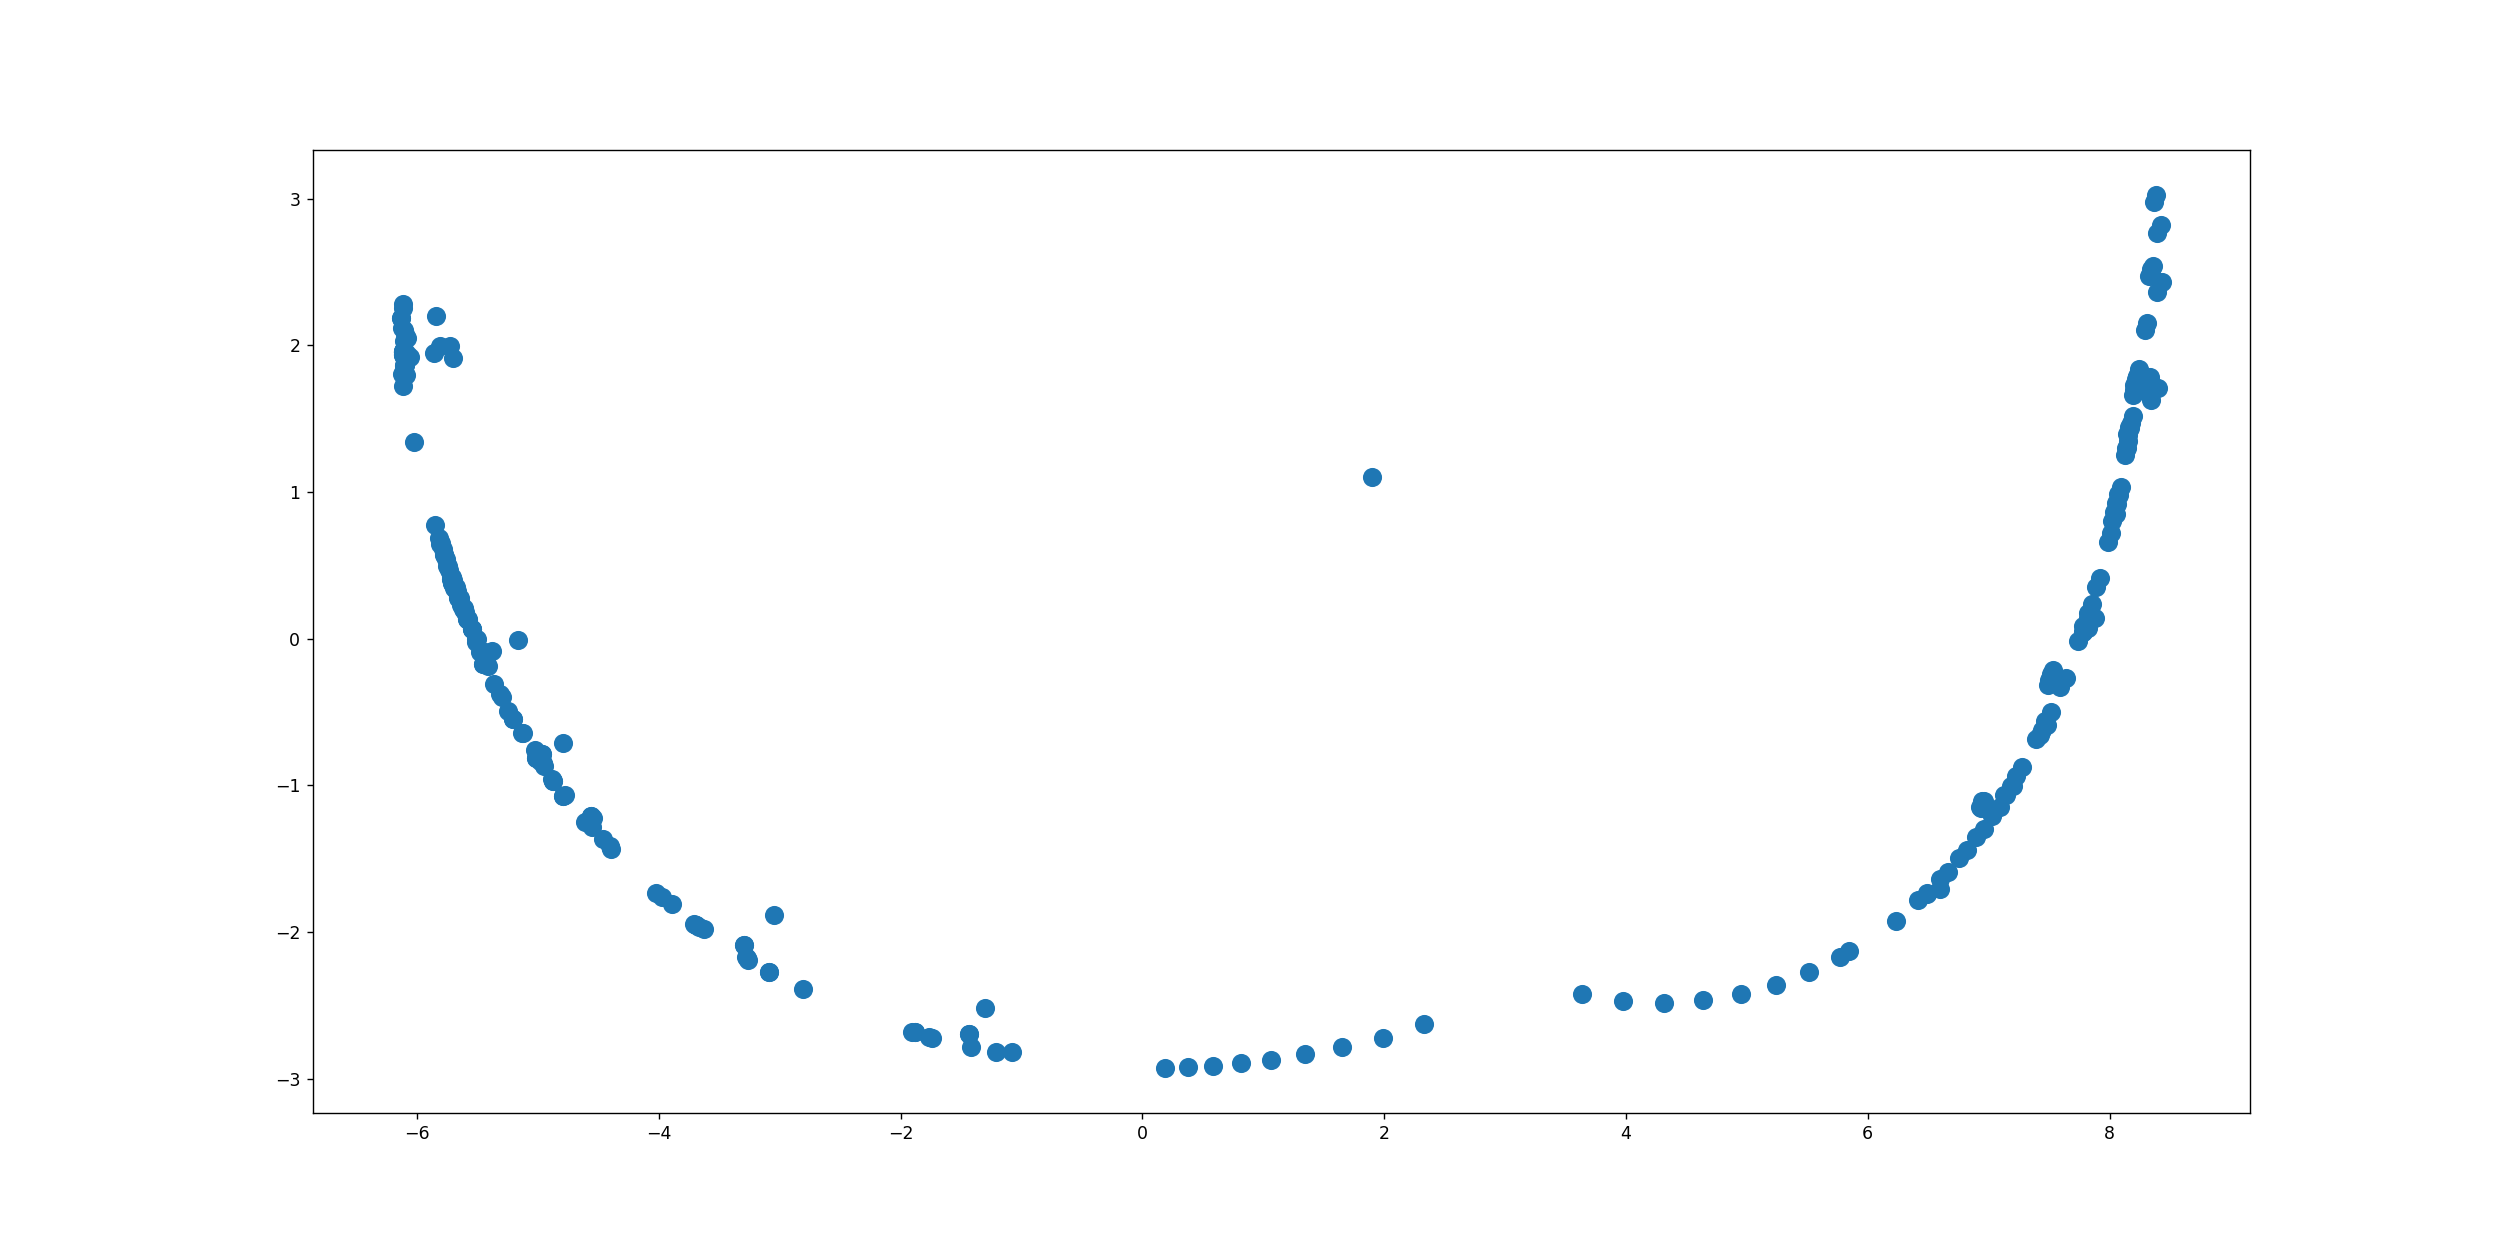

In [41]:
# Approach #4, using supernet as an additional feature and ignore the subnet.

def pre_process_firewall_data(resource_data_json):
    """Pre process resource data.

    Args:
        resource_data_json (list): A list of resource data in json format.
        selected_features (list): A list of selected features, if the
            list is empty, we will include all the features.

    Returns:
        DataFrame: DataFrame table with all the resource_data.
        str: Full name column.
        str: Name of the firewall rule.
    """

    def ip_extraction(x):
        """Pre process ip data.
        Args:
            ip address (string): An ip address with subnet as a string.
        Returns:
            ip: IP extracted from the network.
            supernet: Supernet Ip network form the available ip network.
        """
        if not x:
            return '', ''
        l = []
        ip_add = ipaddress.IPv4Interface(x)
        ip_supernet = ipaddress.ip_network(x).supernet()
        return ip_add.ip, ip_supernet
    
    df = pd.DataFrame(resource_data_json)
    full_name_column, name_column = df['full_name'], df['name']

    df['creation_timestamp'] = df['creation_timestamp'].astype('category').cat.codes
    df['direction'] = df['direction'].astype('category').cat.codes
    df['action'] = df['action'].astype('category').cat.codes
    df['disabled'] = df['disabled'].astype('category').cat.codes
    df['ip_protocol'] = df['ip_protocol'].astype('category').cat.codes
    df['ports'] = df['ports'].astype('category').cat.codes

    df[['source_ip','source_ip_supernet']] = df['source_ip_addr'].apply(lambda x: pd.Series([ip_extraction(x)[0],ip_extraction(x)[1]]))
    df[['dest_ip','dest_ip_supernet']] = df['dest_ip_addr'].apply(lambda x: pd.Series([ip_extraction(x)[0],ip_extraction(x)[1]]))
    df['source_ip'] = df['source_ip'].astype('category').cat.codes
    df['source_ip_supernet'] = df['source_ip_supernet'].astype('category').cat.codes
    df['dest_ip'] = df['dest_ip'].astype('category').cat.codes
    df['dest_ip_supernet'] = df['dest_ip_supernet'].astype('category').cat.codes

    df['service_account'] = df['service_account'].astype('category').cat.codes
    df['tag'] = df['tag'].astype('category').cat.codes
    df['full_name'] = df['full_name'].astype('category').cat.codes
    df['ip_protocol'] = df['ip_protocol'].astype('category').cat.codes
    df['network'] = df['network'].astype('category').cat.codes
    df['source_service_account'] = df['source_service_account'].astype('category').cat.codes
    df['source_tag'] = df['source_tag'].astype('category').cat.codes
    
    df = df.drop(columns=['source_ip_addr', 'dest_ip_addr', 'org_id', 'name', 'creation_timestamp', 'full_name'])
    return df, full_name_column, name_column

with open('sample_datasets/dataset_firewall.json') as firewall_dataset:
    firewall_rules = json.load(firewall_dataset)

    flattened_firewall_rules = FirewallRule.flatten_firewall_rules(firewall_rules)

    flattened_firewall_rules_dict = [i.to_dict() for i in flattened_firewall_rules]

    df_filtered, full_name_col, name_col = pre_process_firewall_data(
        flattened_firewall_rules_dict)
    print (df_filtered.iloc[0])
    
    
pca, pca_2 = dimensionality_reduce(df_filtered, 2)

print (pd.DataFrame(pca.components_,columns=df_filtered.columns,index = ['PC-1','PC-2']))

# weighted_dimension, components, covariance_matrix = principal_components(pca, df_filtered)
# print ("Explained Variance:", weighted_dimension, "Covariance Matrix:", covariance_matrix)
# print ("COMPONENTS SPREAD", components)
# print ("SHAPE OF COVARIANCE MATRIX", covariance_matrix.shape)

# pca_2 = pd.DataFrame(pca_2)

# pca_2['full_name'] = full_name_col

# visualize_2d(pca_2)
print ("")
print ("====== Using similarity matrix ========")

sim_matrix = cosine_similarity(df_filtered)

pca, pca_2 = dimensionality_reduce(sim_matrix, 2)

pca_2 = pd.DataFrame(pca_2)

pca_2['full_name'] = full_name_col
pca_2['name'] = name_col

pca_2['identifier'] = pca_2['full_name'].map(lambda x: str(x) + ' ') + pca_2['name']

pca_2 = pca_2.drop(columns=['full_name', 'name'])

visualize_2d(pca_2)


action                     0
direction                  0
disabled                   0
ip_protocol                0
ports                      3
service_account           11
source_service_account    -1
source_tag                -1
tag                       -1
source_ip                  1
source_ip_supernet         1
dest_ip                    0
dest_ip_supernet           0
Name: 0, dtype: int8
      action     direction      disabled  ip_protocol     ports  \
PC-1    -0.0 -0.000000e+00  5.551115e-17     0.000995  0.013872   
PC-2     0.0  2.775558e-16 -1.110223e-16    -0.000718 -0.021909   

      service_account  source_service_account    source_tag       tag  \
PC-1        -0.402033                    -0.0  1.363426e-44  0.915501   
PC-2         0.915256                     0.0  2.391513e-44  0.402271   

      source_ip  source_ip_supernet  dest_ip  dest_ip_supernet  
PC-1   0.004135            0.004135     -0.0              -0.0  
PC-2  -0.001492           -0.001492      0.0      

<IPython.core.display.Javascript object>


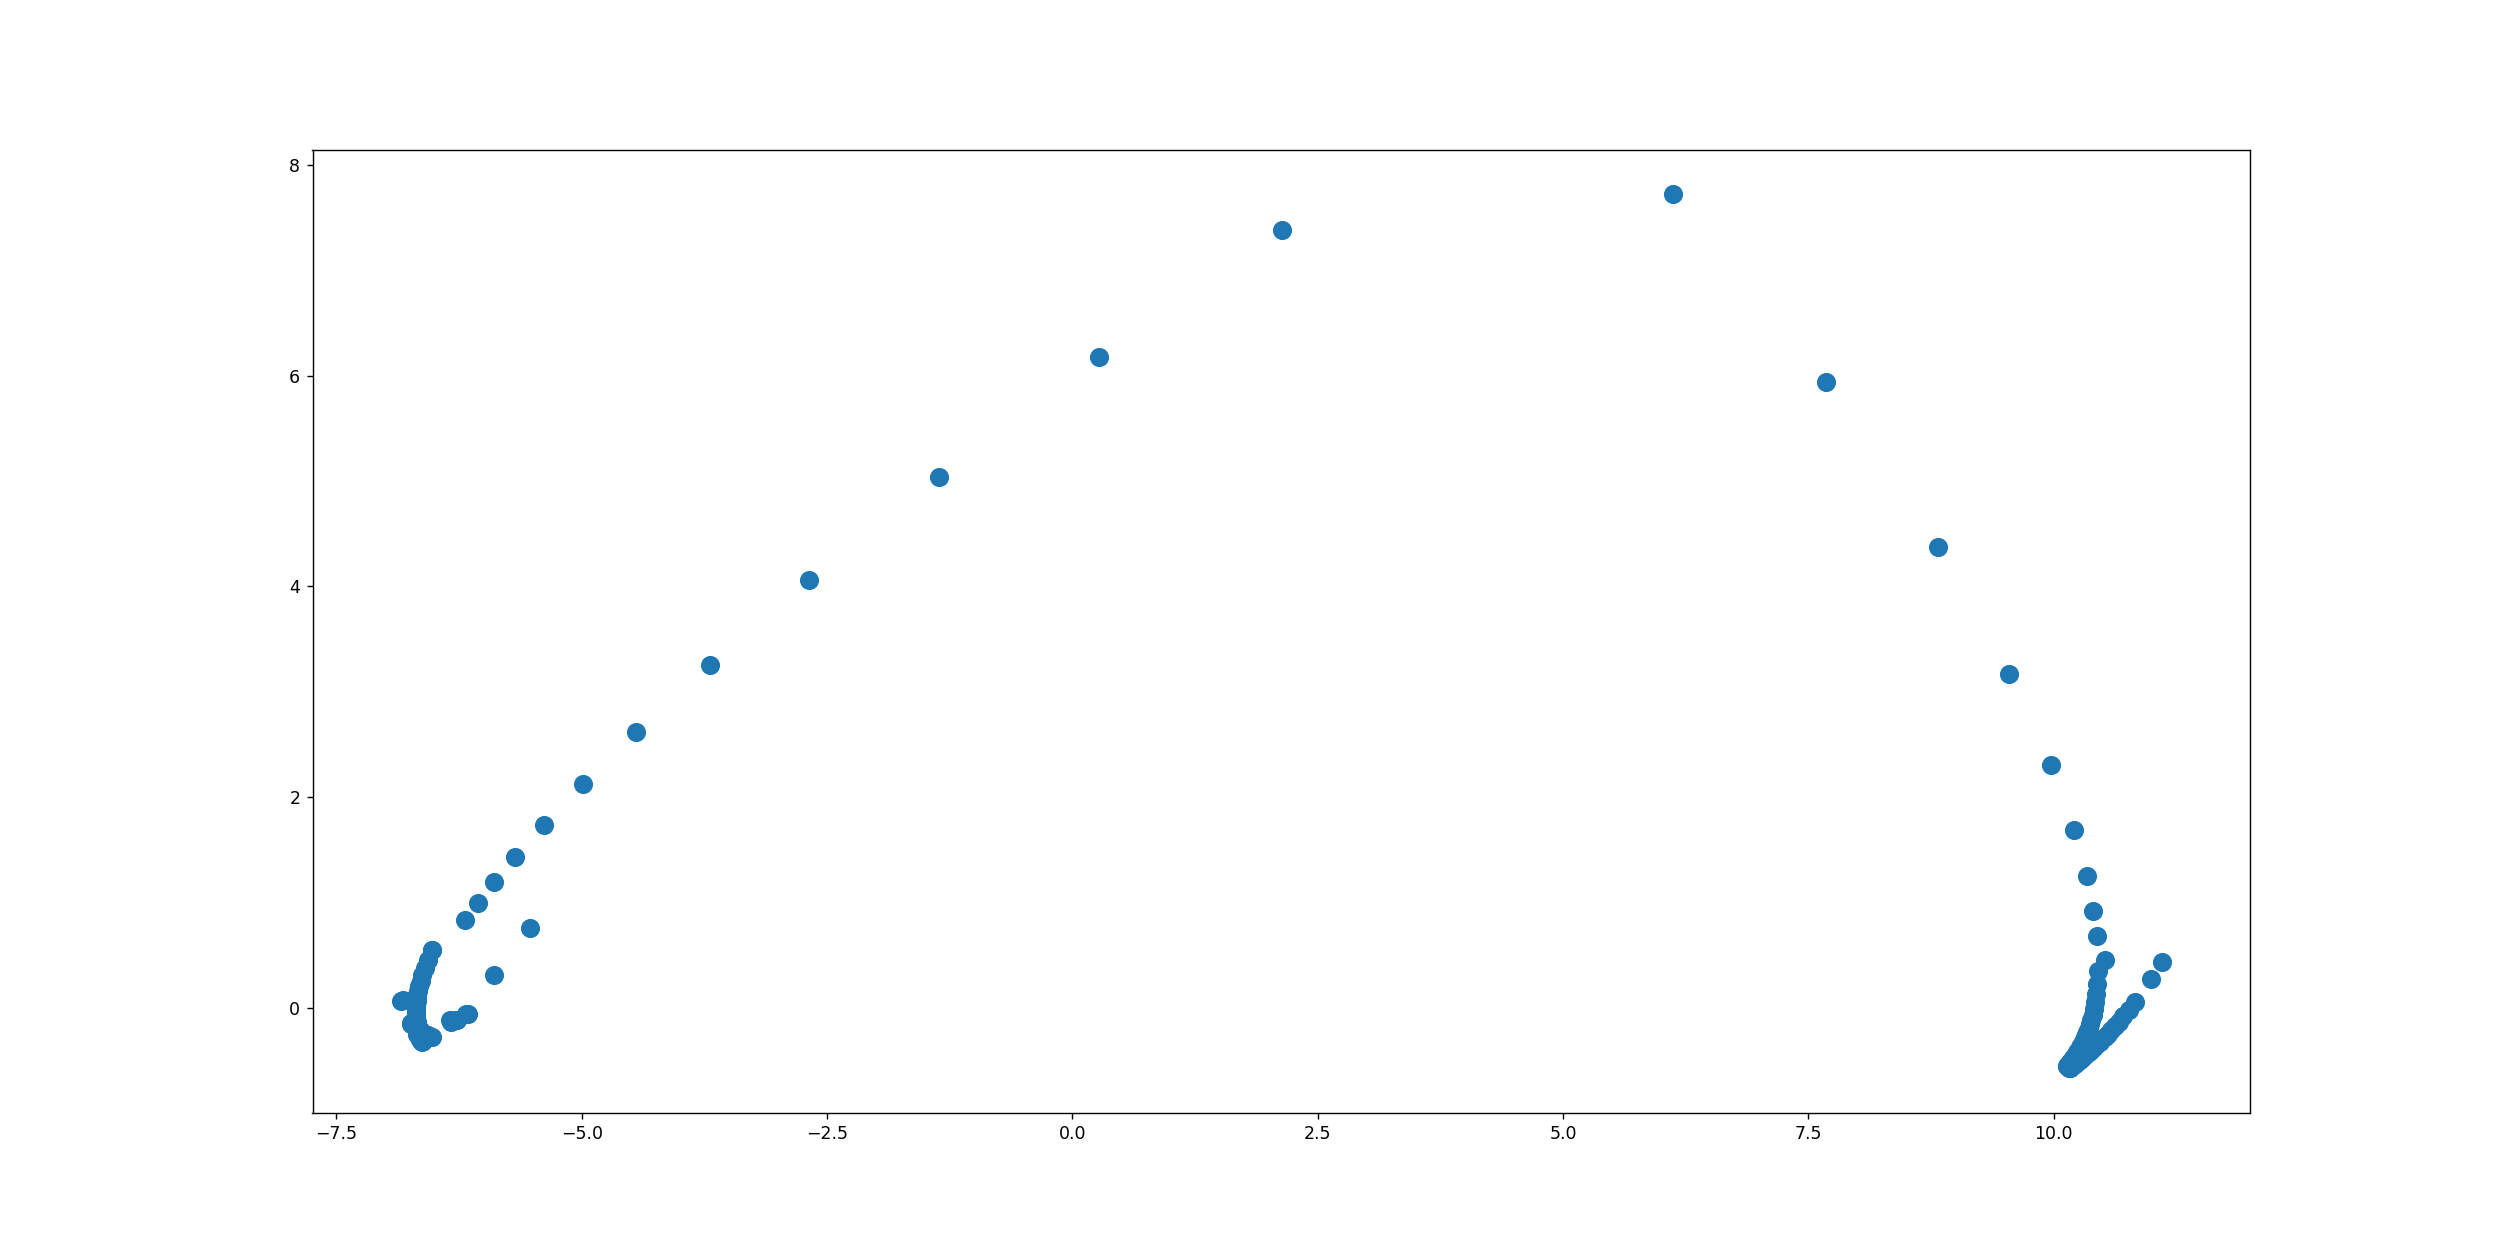

In [30]:
# Approach #5, using supernet as an additional feature and ignore the subnet.
# Drop timestamp, fullname and network columns.

def pre_process_firewall_data(resource_data_json):
    """Pre process resource data.

    Args:
        resource_data_json (list): A list of resource data in json format.
        selected_features (list): A list of selected features, if the
            list is empty, we will include all the features.

    Returns:
        DataFrame: DataFrame table with all the resource_data.
    """

    def ip_extraction(x):
        """Pre process ip data.
        Args:
            ip address (string): An ip address with subnet as a string.
        Returns:
            ip: IP extracted from the network.
            supernet: Supernet Ip network form the available ip network.
        """
        if not x:
            return '', ''
        l = []
        ip_add = ipaddress.IPv4Interface(x)
        ip_supernet = ipaddress.ip_network(x).supernet()
        return ip_add.ip, ip_supernet
    
    df = pd.DataFrame(resource_data_json)
    full_name_column, name_column = df['full_name'], df['name']

    #df['creation_timestamp'] = df['creation_timestamp'].astype('category').cat.codes
    df['direction'] = df['direction'].astype('category').cat.codes
    df['action'] = df['action'].astype('category').cat.codes
    df['disabled'] = df['disabled'].astype('category').cat.codes
    df['ip_protocol'] = df['ip_protocol'].astype('category').cat.codes
    df['ports'] = df['ports'].astype('category').cat.codes

    df[['source_ip','source_ip_supernet']] = df['source_ip_addr'].apply(lambda x: pd.Series([ip_extraction(x)[0],ip_extraction(x)[1]]))
    df[['dest_ip','dest_ip_supernet']] = df['dest_ip_addr'].apply(lambda x: pd.Series([ip_extraction(x)[0],ip_extraction(x)[1]]))
    df['source_ip'] = df['source_ip'].astype('category').cat.codes
    df['source_ip_supernet'] = df['source_ip_supernet'].astype('category').cat.codes
    df['dest_ip'] = df['dest_ip'].astype('category').cat.codes
    df['dest_ip_supernet'] = df['dest_ip_supernet'].astype('category').cat.codes
    df = df.drop(columns=['source_ip_addr', 
                          'dest_ip_addr', 
                          'org_id', 
                          'creation_timestamp', 
                          'network', 
                          'full_name',
                          'name'])

    df['service_account'] = df['service_account'].astype('category').cat.codes
    df['tag'] = df['tag'].astype('category').cat.codes
    #df['full_name'] = df['full_name'].astype('category').cat.codes
    df['ip_protocol'] = df['ip_protocol'].astype('category').cat.codes
    #df['network'] = df['network'].astype('category').cat.codes
    df['source_service_account'] = df['source_service_account'].astype('category').cat.codes
    df['source_tag'] = df['source_tag'].astype('category').cat.codes
    return df, full_name_column, name_column

with open('sample_datasets/dataset_firewall.json') as firewall_dataset:
    firewall_rules = json.load(firewall_dataset)

    flattened_firewall_rules = FirewallRule.flatten_firewall_rules(firewall_rules)

    flattened_firewall_rules_dict = [i.to_dict() for i in flattened_firewall_rules]

    df_filtered, full_name_col, name_col = pre_process_firewall_data(
        flattened_firewall_rules_dict)
    print (df_filtered.iloc[0])
    
    
pca, pca_2 = dimensionality_reduce(df_filtered, 2)

print (pd.DataFrame(pca.components_,columns=df_filtered.columns,index = ['PC-1','PC-2']))

# weighted_dimension, components, covariance_matrix = principal_components(pca, df_filtered)
# print ("Explained Variance:", weighted_dimension, "Covariance Matrix:", covariance_matrix)
# print ("COMPONENTS SPREAD", components)
# print ("SHAPE OF COVARIANCE MATRIX", covariance_matrix.shape)

# pca_2 = pd.DataFrame(pca_2)

# pca_2['full_name'] = full_name_col

# visualize_2d(pca_2)
print ("")
print ("====== Using similarity matrix ========")

sim_matrix = cosine_similarity(df_filtered)

pca, pca_2 = dimensionality_reduce(sim_matrix, 2)

pca_2 = pd.DataFrame(pca_2)

pca_2['full_name'] = full_name_col
pca_2['name'] = name_col

pca_2['identifier'] = pca_2['full_name'].map(lambda x: str(x) + ' ') + pca_2['name']

pca_2 = pca_2.drop(columns=['full_name', 'name'])

visualize_2d(pca_2)

In [4]:
# K means

def k_means(data, num_clusters, max_iter, seed=0):
    """Creates and fits the k-means model with dataset.

    Args:
       seed: Seed with which cluster centroids are
           initialized to track experiments
       data: Array/sparse-matrix each column representing a
           feature and row an instance
       num_clusters: Number of cluster and centroids to create
       max_iter: The maximum number of iterations for a single run

    Returns:
      kmeans: Model which has clustered the dataset
   """
    kmeans = KMeans(n_clusters=num_clusters, random_state=seed,
                    max_iter=max_iter).fit(data)
    return kmeans

m = k_means(df_filtered, 3, max_iter=100, seed=0)

In [ ]:
# Autoencoder
def autoencoder_model(input_shape):
    """
    The model function which computes the embedding.

    This is based on the implementation mentioned here:
    https://arxiv.org/pdf/1511.06335.pdf

    """
    input_layer = layers.Input(shape=input_shape)
    encoder_1 = layers.Dense(500, act='relu', name="encoder_1")(input_layer)
    encoder_2 = layers.Dense(500, act='relu', name="encoder_2")(encoder_1)
    encoder_3 = layers.Dense(2000, act='relu', name="encoder_3")(encoder_2)
    encoder_4 = layers.Dense(10, act='relu', name="encoder_4")(encoder_3)

    hidden = layers.Dense(10, act='relu', name="hidden")(encoder_4)

    decoder_1 = layers.Dense(10, act='relu', name="decoder_1")(hidden)
    decoder_2 = layers.Dense(2000, act='relu', name="decoder_2")(decoder_1)
    decoder_3 = layers.Dense(500, act='relu', name="decoder_3")(decoder_2)
    decoder_4 = layers.Dense(500, act='relu', name="decoder_4")(decoder_3)

    output_layer = layers.Dense(input_shape, name="output_layer")(decoder_4)
    model = Model(inputs=input_layer, outputs=output_layer)

    return model


def embedding_model(model):
    """Returns the Trained model which gives the embeddings as the output.

    Args:
        model: Trained autoencoder model

    Returns:
        intermediate model: Model split till the hidden layer

    """
    intermediate_model = model(
        inputs=[model.input],
        outputs=[model.get_layer("hidden").output])

    return intermediate_model